In [1]:
import numpy as np
import torch
import resnet
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import datasets, transforms

In [2]:
class DataHandler3(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(x)
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

def calculate_dispersed_fishmask(device, net, handler, X, Y, args, pct_top=0.02):
        #---------------------------------Originally calculate_gradients---------------------------------
        net.to(device)
        for param in net.parameters():
            param.requires_grad = True
        net.eval()
        parameters = tuple(net.parameters())
        sq_grads_expect = {i: np.zeros(p.shape) for i, p in enumerate(parameters)}
        test_loader = DataLoader(handler(X, Y, transform=args['transform']), shuffle=False, **args['loader_te_args'])
        num_samples = 2 # used by FISH mask paper
        idx = 0
        for test_batch, test_labels, idxs in test_loader:
            if idx >= num_samples:
                break
            
            test_batch, test_labels = test_batch.cpu(), test_labels.cpu()
            outputs, e1 = net(test_batch)
            _, preds = torch.max(outputs, 1)         
            probs = F.softmax(outputs, dim=1).to('cpu')
            log_probs = F.log_softmax(outputs, dim=1)
            N, C = log_probs.shape
            #print(f'N:{N} C:{C}')
            for n in range(N):
                for c in range(C):
                    grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
                    #if n == 0:
                        #print(f'len:{len(grad_list)}')
                    for i, grad in enumerate(grad_list):    # different layers
                        gsq = torch.square(grad).to('cpu') * probs[n][c] / N
                        sq_grads_expect[i] += gsq.detach().numpy() # sq_grads_expect[i] + gsq
                        del gsq
                    net.zero_grad()
                idx += 1
                if idx >= num_samples:
                    break
        
        grad_values = list(sq_grads_expect.values())
        imp_wt_idxs = [[] for i in range(len(grad_values))]
        for layer in range(len(grad_values)): #layer-by-layer
            num_imp = np.ceil(pct_top * np.prod(np.array(grad_values[layer]).shape))
            print(num_imp,np.prod(np.array(grad_values[layer]).shape))
            sorted_grads = np.argsort(grad_values[layer],axis=None)
            top_grad_idxs = sorted_grads[-int(num_imp):]
            #top_grad_idxs = np.hstack([np.array(t).flatten() for t in top_grad_idxs])
            #flat_layer = np.array(grad_values[layer]).flatten()
            for idx in top_grad_idxs:
                try:
                    #imp_wt_idxs[i].append(np.nonzero(flat_layer[idx] == grad_values[i]))
                    imp_wt_idxs[layer].append(np.unravel_index(idx, grad_values[layer].shape))
                except Exception:
                    print("caught error: ", layer, len(np.array(grad_values[layer]).flatten()), len(top_grad_idxs), top_grad_idxs)
                    raise

        return imp_wt_idxs


def calculate_relative_fishmask(device, net, handler, X, Y, args, pct_top=0.02):
        #---------------------------------Originally calculate_gradients---------------------------------
        net.to(device)
        for param in net.parameters():
            param.requires_grad = True
        net.eval()
        parameters = tuple(net.parameters())
        sq_grads_expect = {i: np.zeros(p.shape) for i, p in enumerate(parameters)}
        test_loader = DataLoader(handler(X, Y, transform=args['transform']), shuffle=False, **args['loader_te_args'])
        num_samples = 2 # used by FISH mask paper
        idx = 0
        for test_batch, test_labels, idxs in test_loader:
            if idx >= num_samples:
                break
            
            test_batch, test_labels = test_batch.cpu(), test_labels.cpu()
            outputs, e1 = net(test_batch)
            _, preds = torch.max(outputs, 1)         
            probs = F.softmax(outputs, dim=1).to('cpu')
            log_probs = F.log_softmax(outputs, dim=1)
            N, C = log_probs.shape
            #print(f'N:{N} C:{C}')
            for n in range(N):
                for c in range(C):
                    grad_list = torch.autograd.grad(log_probs[n][c], parameters, retain_graph=True)
                    #if n == 0:
                        #print(f'len:{len(grad_list)}')
                    for i, grad in enumerate(grad_list):    # different layers
                        gsq = torch.square(grad).to('cpu') * probs[n][c] / N
                        sq_grads_expect[i] += gsq.detach().numpy() # sq_grads_expect[i] + gsq
                        del gsq
                    net.zero_grad()
                idx += 1
                if idx >= num_samples:
                    break
        
        grad_values = list(sq_grads_expect.values())
        imp_wt_idxs = [[] for i in range(len(grad_values))]
        for layer in range(len(grad_values)): #layer-by-layer
            #num_imp = np.ceil(pct_top * np.prod(np.array(grad_values[layer]).shape))
            layer_avg = np.average(grad_values[i])
            sorted_grads = np.argsort(grad_values[layer],axis=None)
            flat_layer = np.array(grad_values[layer]).flatten()
            top_grad_idxs = [i for i in sorted_grads if flat_layer[i] > layer_avg*1.25]
            #print(layer_avg, grad_values[sorted_grads[0]])
            for idx in top_grad_idxs:
                try:
                    imp_wt_idxs[layer].append(np.unravel_index(idx, grad_values[layer].shape))
                except Exception:
                    print("caught error: ", layer, len(np.array(grad_values[layer]).flatten()), len(top_grad_idxs), top_grad_idxs)
                    raise

        return imp_wt_idxs

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = resnet.ResNet18()
handler = DataHandler3
data_tr = datasets.CIFAR10('data/CIFAR10', train=True, download=True)
data_te = datasets.CIFAR10('data/CIFAR10', train=False, download=True)
X_tr = data_tr.data
Y_tr = torch.from_numpy(np.array(data_tr.targets))
X_te = data_te.data
Y_te = torch.from_numpy(np.array(data_te.targets))
args_pool = {
                'n_epoch': 3, 'transform': transforms.Compose([ 
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                ]),
                'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                'loader_te_args':{'batch_size': 100, 'num_workers': 1}, # change back to 1000
                'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
            }

imp_wt_idxs = calculate_relative_fishmask(device, net, handler, X_tr, Y_tr, args_pool, pct_top=0.01)

Files already downloaded and verified
Files already downloaded and verified


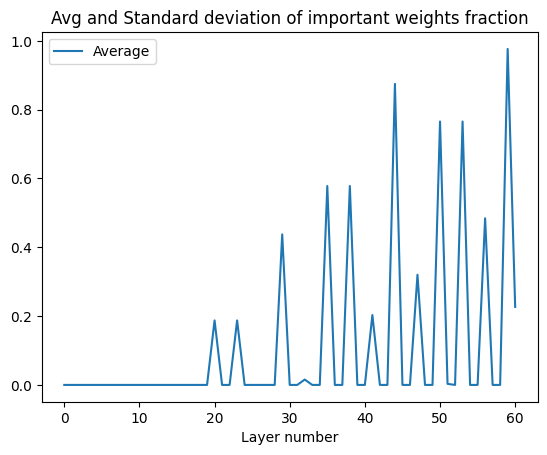

In [4]:
import torch
import resnet
import numpy as np

model = resnet.ResNet18()
frac_imp = {l: [] for l in range(len(imp_wt_idxs))}
for layer_num, param in enumerate(model.parameters()):
    #print(len(imp_wt_idxs[layer_num]), np.prod(param.shape))
    frac_imp[layer_num] = [len(imp_wt_idxs[layer_num]) / np.prod(param.shape)]

import matplotlib.pyplot as plt
plt.plot([np.average(frac_imp[l]) for l in range(61)], label='Average')
#plt.plot([frac_imp[l] for l in range(61)], label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of important weights fraction')
plt.legend()
#plt.savefig("impwtsperlayerstats.png", format="png", dpi=5000)
plt.show()